# User Guide

## Import packages and load data

Before we start, we need to load an example image (here an image cube with 5 bands) *and* a detection catalog.
If such a catalog is not available, packages like [SEP](http://sep.readthedocs.io/) or [photutils](https://photutils.readthedocs.io/en/stable/) will happily generate one.
Instead, we will simply load the truth catalog of the simulation.
While not fundamentally needed, *scarlet* works best if the background noise levels are known as well, so we'll also set it to the true value:

In [31]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

import numpy as np
import scarlet

# Load the sample images
# Load the sample images
data = np.load("../data/psf_unmatched_sim.npz")
images = data["images"]
filters = data["filters"]
psfs = data["psfs"]
catalog = data["catalog"]
bg_rms = np.array([20]*len(images))

## Introduction

The purpose of this guide is to explain the basic concepts of the *scarlet* package and how they are used. We also show how they can be extended and customized for more specialized science cases.
The [API Documentation](api_docs.rst) contains more detailed descriptions of the modules and classes used in *scarlet*, and a more rigorous overview of the mathematics and algorithms used by *scarlet* is described in [Melchior et al. 2018](https://arxiv.org/abs/1802.10157).

### Basic Concepts and Structure

The goal of *scarlet* is to create a model of individual astrophysical sources from a collection of observations of a blended region of the sky. These observations can be in multiple filter bands, telescopes with different resolutions, and eventually even spectral or grism detectors. As is pointed out by Robert Lupton, perfect reconstruction of a blended scene is [impossible](https://docushare.lsst.org/docushare/dsweb/Services/Document-29071), however by making a few minor assumptions *scarlet* improves on other blending algorithms by leveraging as much data as possible.

The basic assumption of *scarlet* is that the sources in an astrophysical image can be thought of as a collection of multiple [Component](component.ipynb#scarlet.component.Component) objects, where each component has a single morphology (shape) that is the same in each band (SED). In this model more complicated objects, like galaxies, can be thought of as a combination multiple components (a [ComponentTree](component.ipynb#scarlet.component.ComponentTree)), where components with different SEDs represent different populations of stars or gases in the host galaxy. In order to properly separate sources further assumptions are required, for example assuming that all of the flux is positive and stars and galaxies monotonically decrease from their centers. The use of constraints is discussed in more detail in [Updates and Constraints](#Updates-and-Constraints).

A [Scene](observation.ipynb#scarlet.observation.Scene) contains the metadata for a given *scarlet* model, which represents the deblended sources from an image created from an [Observation](observation.ipynb#scarlet.observation.Observation) or multiple observations. Each observation can have multiple filter bands with a different PSF in each band that is internally matched to the target PSF of the model [Scene](observation.ipynb#scarlet.observation.Scene). This allows the model to be convolved into each observed frame for comparison with the input data.

Finally the [Blend](blend.ipynb#scarlet.blend.Blend) class contains the `scene`, `observations`, and `sources` (a list of [Component](component.ipynb#scarlet.component.Component) or [ComponentTree](component.ipynb#scarlet.component.ComponentTree) objects) and executes the optimization algorithm. [Blend](blend.ipynb#scarlet.blend.Blend) also implements the minimization algorithm described in [Melchior et al. 2018](https://arxiv.org/abs/1802.10157), which is briefly described below:

The deblending algorithm forms a model of the scene

$$\mathsf{M}= \sum_{k=1}^K \mathsf{A}_k^T \times \mathsf{S}_k = \mathsf{A}\mathsf{S}, $$

where $\mathsf{A}_k \in \mathbb{R}^B$ is the normalized SED and $\mathsf{S}_k \in \mathbb{R}^N$ is the morphology of a single component in the model with $B$ bands and $N$ pixels in each band.
It is important to note that this matrix factorization implies that SEDs and morphologies are independent, e.g. the SED of a component does not change over the region covered by its morphology.

The scene is fit by minimizing the likelihood of the model, namely minimizing

$$f(\mathsf{A},\mathsf{S}) = \frac{1}{2} || \mathsf{Y}-\mathsf{A}\mathsf{S} ||_2^2, $$

where $\mathsf{Y}$ is an image cube and $||.||_2$ is the element-wise $L_2$ (Frobenius) norm.
Each component $j$ can have $M_j$ different constraint functions $g_{ji}$, equivalent to minimizing
$$f(\mathsf{A}, \mathsf{S}) + \sum_{j=1}^K \sum_{i=1}^{M_j} g^A_{ji} \left(\mathsf{A}_{ji} \right) + g^S_{ji} \left(\mathsf{S}_{ji} \right)$$

Those constraints are applied to each source in the form of proximal operators, a handy mathematical approach for imposing non-smooth constraints that (if properly formulated) are guaranteed to converge; the curious reader will find more details in [Parikh & Boyd 2014](http://www.web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf) and [Combettes & Pesquet 2011](https://link.springer.com/chapter/10.1007/978-1-4419-9569-8_10).
In short, proximal operators map an input vector to the nearest vector that satisfied the respective constraint.
Many constraints/penalty functions have analytic proximal operators. 

Note that the PSF of the model $\mathsf{M}$ above is the target PSF of the [Scene](observation.ipynb#scarlet.observation.Scene), meaning the likelihood we evaluate is more complicated due to an extra PSF convolution performed in each band to with the difference kernel to match the seeing in each [Observation](observation.ipynb#scarlet.observation.Observation) filter band. *scarlet* uses the [autograd](https://github.com/HIPS/autograd) package to calculate the gradient of this more complicated model in each iteration during optimization.

## Observations and Scene

The [Observation](observation.ipynb#scarlet.observation.Observation) and [Scene](observation.ipynb#scarlet.observation.Scene) are usually the first two objects you can expect to initialize when using *scarlet*. Unless you are working with PSF matched coadds you will need to pass the PSF in each band to the [Observation](observation.ipynb#scarlet.observation.Observation) and the define a target psf for the [Scene](observation.ipynb#scarlet.observation.Scene). The `target_psf` is recommended to be a gaussian and should always be well sampled ($\sigma \geq 1/\sqrt{2}$) and narrower or equal to the best seeing PSF in all of the observations. If combining ground and space based data it is appropriate to use the seeing of the space telescope.

For example, we can define the target PSF using

In [2]:
# Define the pixel grid
X = np.arange(psfs.shape[2])
Y = np.arange(psfs.shape[1])
X, Y = np.meshgrid(X, Y)
coords = np.stack([Y, X])
y0, x0 = (psfs.shape[1]-1) // 2, (psfs.shape[2]-1) // 2
# Use a narrow gaussian as the target PSF
target_psf = scarlet.psf.gaussian(coords, y0, x0, 1, .9)
# Normalize the target_psf so that the input flux is not rescaled
target_psf /= target_psf.sum()

Assuming that our observations are all from a single camera and that the [Observation](observation.ipynb#scarlet.observation.Observation) and [Scene](observation.ipynb#scarlet.observation.Scene) both use the same pixel scale, we can initialize the `observations` and `scene` using

In [3]:
observation = scarlet.Observation(images, psfs)
scene = scarlet.Scene(images.shape, psfs=target_psf)

If you are working with observations at different resolutions see ???? for more information on multi-resolution deblending.

## Components and Sources

As described in the [introduction](#Basic-Concepts-and-Structure), a [Component](component.ipynb#scarlet.component.Component) is a feature of a source that has the same morphology in each band. For example a star is a single component source while resolved galaxies may have a bulge component and a disk component and even more advanced components like a jet or dust lanes. A component must be initialized with `sed` and `morph` (morphology) attributes which can optionally be fixed (e.g. a fixed SED if a reliable spectrum exists for the object or a fixed point-like morphology for a known star) or updated by the [Blend](blend.ipynb#scarlet.blend.Blend) class during optimization. A component can also be initiazed with a [Prior](component.ipynb#scarlet.component.Prior), a constraint applied as an an update to the gradient of the likelihood for the given component.

### Initialization

The recommended way of adding a new component to a blend is to use a custom or built-in class derived from [Component](component.ipynb#scarlet.component.Component). For many users the built in sources
* [PointSource](source.ipynb#scarlet.source.PointSource)
* [ExtendedSource](source.ipynb#scarlet.source.ExtendedSource)
* [MultiComponentSource](source.ipynb#scarlet.source.MultiComponentSource)

will be a good place to start, but for illustrative purposes we can initialize a simple point source component using

In [4]:
# The (y, x) location of the source
center = (int(catalog["y"][0]), int(catalog["x"][0]))
# Get the SED for each observation at the location of the central pixel
sed = scarlet.source.get_pixel_sed(center, scene, [observation])
# Set the morphology such that only the central pixel has any intensity
morph = np.zeros((scene.Ny, scene.Nx))
morph[center] = 1
comp = scarlet.Component(sed, morph)

In the case of a known star it might also be useful to fix the morphology and allow only the amplitude in each band to be updated:

In [5]:
point_source = scarlet.PointSource(center, scene, observation, fix_morph=True)

But most of the time the type of source is unknown and could potentially be an extended object, like a galaxy. In that case it is useful to initialize each source as an [ExtendedSource](source.ipynb#scarlet.source.ExtendedSource) that is initialized to be both symmetric and monotonic about its center. A final caveat is that *scarlet* does not do any detection and requires an input catalog for each source. Because most object detection algorithms operate in a single band, possibly with some merging of catalogs between bands and epochs, there is a tradeoff between tweaking a detection algorithm to detect the faintest sources in a blend vs trying to minimize spurrious detections of noise or wings of bright sources. As we will see later, undetected objects can have adverse effects on their detected neighbors, meaning it is often better to crank up detection at the risk of having more spurrious objects.

A consequence of this behavior is that there are likely to be some detected peaks that don't have significant flux above the noise level, resulting in an inability of *scarlet* to initialize them and causing a [SourceInitError](source.ipynb#scarlet.source.SourceInitError). How you handle these spurrious objects will be specific to your science case, however one option to attempt to separate truly spurrious detections from barely detected sources is:

In [6]:
sources = []
for idx in np.unique(catalog["index"]):
    # The catalog has multiple components for some sources,
    # so we only need the positions from the first component
    src = catalog[catalog["index"]==idx][0]
    try:
        new_source = scarlet.ExtendedSource((src['y'],src['x']), scene, observation, bg_rms)
    except scarlet.SourceInitError:
        # The source may not have had sufficient flux to be initialized as an
        # extended source, but there might be enough flux at the center in one
        # or more bands to initialize it as a point source
        try:
            new_source = scarlet.PointSource((src['y'], src['x']), scene, observation)
        except scarlet.SourceInitError:
            # None of the default scarlet classes can handle this particular source
            # Either you will need to create your own initialization method or
            # ignore this source
            print("Could not initialze source at (src['y'], src['x'])")
            continue
    sources.append(new_source)

### Displaying a model

Before we start to constrain and fit the model this is a useful time to learn how to display a scarlet model.

#### Display functions

The [display](display.ipynb) module contains a number of convenience methods to convert an image cube into an RGB image array.

There are two stock classes used to scale the pixels in the image, [Linear](display.ipynb#scarlet.display.Linear) and [Asinh](display.ipynb#scarlet.display.Asinh), both of which inherit from the `matplotlib.colors.Normalize` class.
This inheritance allows them to be used as normalizations in `matplotlib.pyplot.imshow`, including an `inverse` method that makes it possible to add a colorbar.

The [Asinh](display.ipynb#scarlet.display.Asinh) scaling is popular because it is linear for small values and logrithmic for larger fluxes, allowing it to display a wide range of intensities clearly.
The actual formula used to scale each pixel is

$$f(x) = \frac{1}{Q} \sinh^{-1} \left( Q \frac{x-v_\textrm{min}}{v_\textrm{max}-v_\textrm{min}} \right)$$

where `Q` is a parameter that defines the strech of the scaling.

Using the [display](display.ipynb) module we can now show an image of the entire blend:

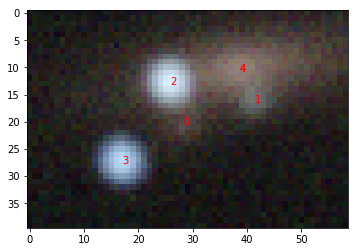

In [32]:
import scarlet.display

# Set the arcsinh color scaling object
asinh = scarlet.display.Asinh(img=images, Q=50)
# Scale the RGB channels for the image
img_rgb = scarlet.display.img_to_rgb(images, filter_indices=[3,2,1], norm=asinh)
# Display the image
plt.imshow(img_rgb)
# Mark each source from the catalog in the image
for src in catalog:
    plt.text(src["x"], src["y"], src["index"], color="r")
plt.show()

The code below shows an example of how to display all of the sources in a model to compare it with the same footprint in the observed images and will be used throughout the remainder of this document. It is beyond the scope of this document to explain in detail how this function works with [matplotlib](https://matplotlib.org) to create the plots, but it is a convenience tool to display all sources and components in a given model:

In [8]:
# Display the sources
def display_sources(sources, observation, norm=None, subset=None, combine=False, show_sed=True):
    """Display the data and model for all sources in a blend
    
    This convenience function is used to display all (or a subset) of
    the sources and (optionally) their SED's.
    """
    if subset is None:
        # Show all sources in the blend
        subset = range(len(sources))
    for m in subset:
        # Load the model for the source
        src = sources[m]
        if hasattr(src, "components"):
            components = len(src.components)
        else:
            components = 1
        # Convolve the model with the psfs in the observation
        model = observation.get_model(src.get_model())
        # Extract the bounding box that contains the non-zero
        # pixels in the model
        bbox = scarlet.bbox.trim(np.sum(model, axis=0), min_value=1e-2)
        bb = (slice(None), *bbox.slices)
        
        # Select the image patch the overlaps with the source and convert it to an RGB image
        img_rgb = scarlet.display.img_to_rgb(images[bb], filter_indices=[3,2,1], norm=norm)

        # Build a model for each component in the model
        if hasattr(src, "components"):
            rgb = []
            for component in src.components:
                # Convert the model to an RGB image
                _model = observation.get_model(component.get_model())
                _rgb = scarlet.display.img_to_rgb(_model[bb], filter_indices=[3,2,1], norm=norm)
                rgb.append(_rgb)
        else:
            # There is only a single component
            rgb = [scarlet.display.img_to_rgb(model[bb], filter_indices=[3,2,1], norm=norm)]

        # Display the image and model
        figsize = [6,3]
        columns = 2
        # Calculate the number of columns needed and shape of the figure
        if show_sed:
            figsize[0] += 3
            columns += 1
        if not combine:
            figsize[0] += 3*(components-1)
            columns += components-1
        # Build the figure
        fig = plt.figure(figsize=figsize)
        ax = [fig.add_subplot(1,columns,n+1) for n in range(columns)]
        ax[0].imshow(img_rgb)
        ax[0].set_title("Data: Source {0}".format(m))
        for n, _rgb in enumerate(rgb):
            ax[n+1].imshow(_rgb)
            if combine:
                ax[n+1].set_title("Initial Model")
            else:
                ax[n+1].set_title("Component {0}".format(n))
        if show_sed:
            if components > 1:
                for comp in src:
                    ax[-1].plot(comp.sed)
            else:
                ax[-1].plot(src.sed)
            ax[-1].set_title("SED")
            ax[-1].set_xlabel("Band")
            ax[-1].set_ylabel("Intensity")
        # Mark the current source in the image
        if components > 1:
            y,x = src.components[0].pixel_center
        else:
            y,x = src.pixel_center
        ax[0].plot(x-bb[2].start, y-bb[1].start, 'rx', mew=2)
        plt.tight_layout()
        plt.show()

We can now use this function to display the initial guess for all detected sources in the blend:

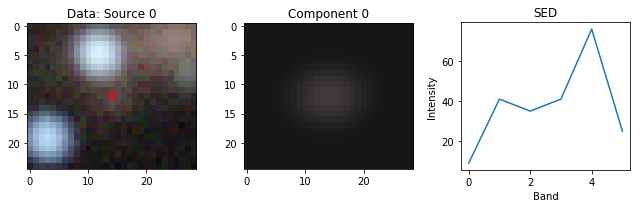

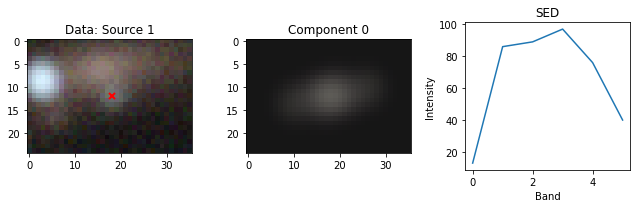

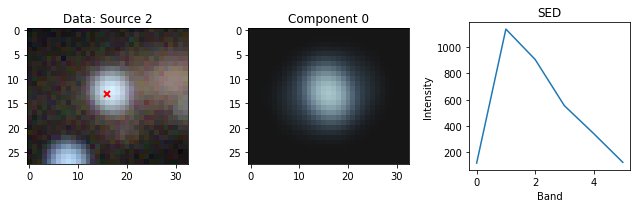

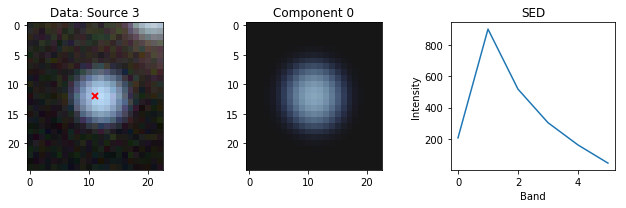

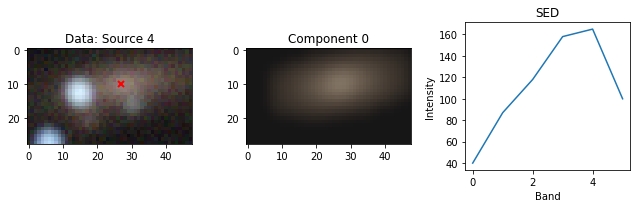

In [9]:
# In order to display the models in the observed seeing
# we have to match the PSFs in the model Scene
# the PSFs in the Observation.
# This is done automatically by Blend but since we
# haven't setup the blend yet we need to do this manually
observation.match(scene)
# Show the initial guess for all sources
display_sources(sources, observation, norm=asinh)

### Hierarchical Sources

In cases where it makes sense to group a collection of components into a single source, for example a galaxy with a bulge and disk, a source class can be derived from [ComponentTree](component.ipynb#scarlet.component.ComponentTree). A component tree is a hierarchical container with all of the same methods as [Component](component.ipynb#scarlet.component.Component), only methods like [get_flux](component.ipynb#scarlet.component.ComponentTree.get_fux) and [get_model](component.ipynb#scarlet.component.ComponentTree.get_model) combine the results from all of the children in the tree.

A sample [MultiComponentSource](source.ipynb#scarlet.source.MultiComponentSource) class is included in *scarlet* and gives an example of one way to initialize a bulge-disk galaxy, however this class has not been adequately tested and should only be used as a starting point to derive your own multi-component source class. If you come up with a class that works better please submit a pull request to add it to *scarlet*, we would be happy to include it!

The example below models all of the sources with two components and displays the initial:

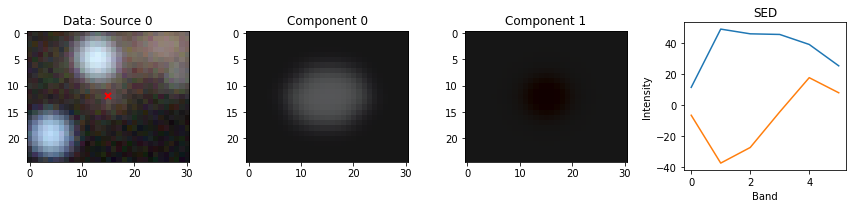

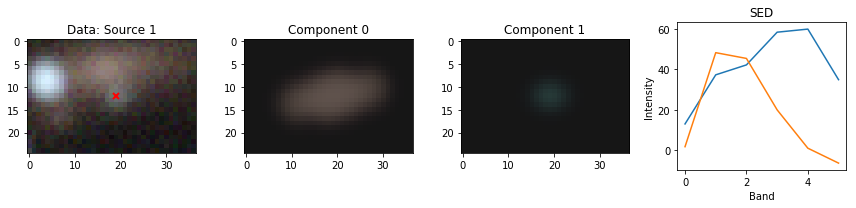

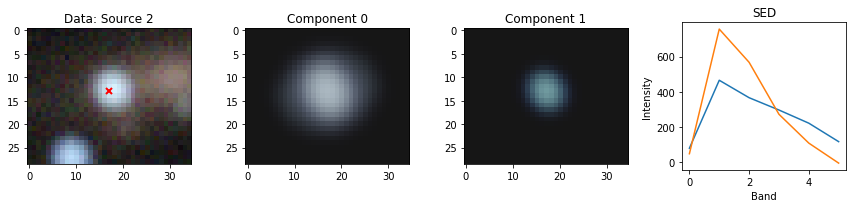

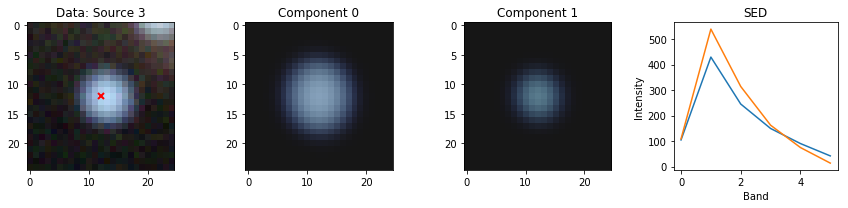

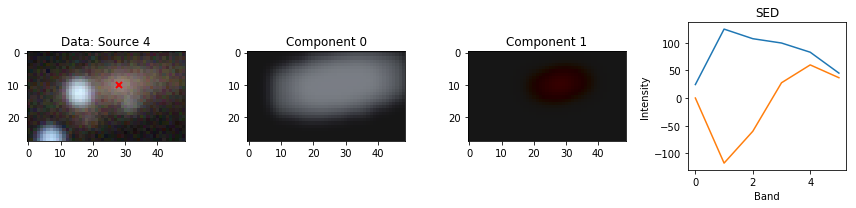

In [10]:
sources = []
for idx in np.unique(catalog["index"]):
    # The catalog has multiple components for some sources,
    # so we only need the positions from the first component
    src = catalog[catalog["index"]==idx][0]
    
    new_source = scarlet.MultiComponentSource((src['y'],src['x']), scene, observation, bg_rms)
    sources.append(new_source)

display_sources(sources, observation, norm=asinh)

As you can see from the plots, there are still improvements needed to the [MultiComponentSource](source.ipynb#scarlet.source.MultiComponentSource) class but this should illustrate how a multi-component source can be created and displayed.

## Updates and Constraints

Components conatain gradients in the `sed_grad` and `morph_grad` attributes that are updated by [Blend](blend.ipynb#scarlet.blend.Blend) in each iteration. Once the gradient updates have been applied to all of the components blend will call [Component.update](component.ipynb#scarlet.component.Component.update) on each component to apply any constraints.

All components should have at least one minimal constraints that is necessary to break degeneracies in the model. For example, given the basic model of the scene 

$$\mathsf{M}= \sum_{k=1}^K \mathsf{A}_k^T \times \mathsf{S}_k = \mathsf{A}\mathsf{S}, $$

there are an infinite number of solutions that can be obtained by multiplying a column in $\mathsf{A}$ by some number $\alpha$ and dividing its corresponding row in $\mathsf{S}$ by the same number $\alpha$. So some normalization is required to give the gradients a more defined direction. As mentioned in the [introduction](#Basic-Concepts-and-Structure), constraints are applied as proximal operators which can simplistically be thought of as projections of a model parameter to the space where the constraint is met. For example, we can define the SED to normalize to one by dividing the SED by `component.sed.sum()` and multiplying `component.morph` by the same value.

### Constructing a new Constraint

The [proxmin](https://github.com/pmelchior/proxmin) package contains many of the basic proximal operators required, with additional proximal operators and update functions found in the [update](update.ipynb) module. Perhaps the best way to illustrate how to use constraints is to re-create a basic update method contained in *scarlet*.

Since flux emitted by sources should typically be non-negative (for now we ignore absorption by dust which would be governed by more complicated constraints) we can project all negative values in the `morph` and `sed` to zero. By convention we define each update function to accept a [Component](component.ipynb#scarlet.component.Component) as the first argument, update or create attributes of that method in place, and return the modified [Component](component.ipynb#scarlet.component.Component). So the function to enforce non-negativity on the sed is just

In [11]:
from proxmin.operators import prox_plus

def positive_sed(component):
    """Make the SED non-negative
    """
    prox_plus(component.sed, component.step_sed)
    return component

Now we can create a source that only uses our new constraint by inheriting from `PointSource` and overloading the `update` method:

In [12]:
import scarlet.update as update
class MinimallyConstrainedSource(scarlet.PointSource):
    def update(self):
        """A minimal source with only normalization and non-negativity
        """
        # Make the sed non-negative
        positive_sed(self)
        # Make the morphology non-negative
        update.positive_morph(self)
        # Normalize the SED to sum to unity
        update.normalized(self, 'sed')

### Normalization

As mentioned [above](#Updates-and-Constraints), in order to break the degeneracy between the sed and morphology we need to normalize one of the two parameters. While the user may use any normalization that suits his/her needs, the [normalized](update.ipynb#normalized) method implements several useful normalization schemes

1. `sed`
2. `morph`
3. `morph_max`

Passing `type="sed"` to [normalized](update.ipynb#normalized) normalizes the `sed` so that its elements sum to unity, making `sed` a normalized SED while `morph` contains all of of the shape and intensity information. This has the advantage that the SED, which converges much faster, is stable for the majority of the iterations. The disadvantage is that overlapping sources that are roughly the same color but have very different intensities (which is common in galaxy clusters, for example) can be difficult to separate with this normalization.

Using `type="morph"` normalizes the `morph` matrix so that it sums to unity for each source, so that `sed` now contains both color and intensity information. The advantage to this method is that two sources with very similar colors are easier to distinguish if they have very different intensities. The other big advantage of this normalization is that true point sources can be fit much more easily and efficiently by fixing the morphology and normalizing `morph`, meaning the intensity of the central pixel equals 1 for all iterations and only the colors and intensities in `sed` are modified.

The main disadvantage of this method is that using `type="morph"` for an [ExtendedSource](#scarlet.source.ExtendedSource) causes fluctuations in the values of the outer pixels during fitting to affect the overall global normalization of `morph` for each source, meaning a peak pixel that is relatively well constrained will not be fixed if a large number of pixels on the outer edges of the source change value (which can happen while fitting regions with low signal to noise, especially if they overlap with another source).

To limit this affect we provide the `type="morph_max"` normalization, which normalizes `morph` so that the peak is always set to a value of 1. This should make the values near the peak more robust and usually results in faster convergence and lower residuals compared to the other two normalization schemes. For this reason it is the default normalization in *scarlet*.

For more on modeling points sources see the [Point Source Tutorial](tutorials/point_source.ipynb).

### Symmetry

Demanding that astrophysical sources are symmetric reduces the number of effective degrees of freedom of the model, and most galaxies are *largely* symmetric. The idea of using symmetry as a constraint has been used successfully in the SDSS deblender and also in our tests on substantially deeper HSC images. If this constraint feels overly restrictive, recall that most galaxy model fitting is done using Sersic profiles, which is much more restrictive than simple $180^\circ$ symmetry.

To make a source symmetric requires a position to make the model symmetric about. The model is highy sensitive to this fractional pixel location so it is necessary to include an update function that estimates the position of a symmetric source in the blend. See [Center Positions](#Center-Positions) for more on setting the center of a source.

### Monotonicity

Another useful constraint from the SDSS-HSC deblender is the approximation that most astrophysical objects are monotonically decreasing from the peak.
In detail this assumption is violated e.g. in spiral galxies, especially tightly wound ones.
But if we think of spirals as a single source made up of multiple components, each monotonically decreasing from it's peak with a single SED, we can build a model that is well representative of even morphologically complex galaxies.
This point of view has the added benefit that regions that are not monotonically decreasing in a galaxy are likely different stellar populations with (potentially) different SED's and should be treated as separate components anyway.

In *scarlet* monotonicity is implemented as a projection that is *not* a true proximal operator. While it is possible to write monotonicity as a true proximal operator, the implementation of the algorithm is far too expensive for any practical deblending purpose. Instead the morphology is projected into a space that has *a* monotonic solution, just not the ideal one. There are two possible monotonic solutions to use. If `use_nearest=True` then only a single reference pixel is used: the nearest one in the direction to the peak.
Otherwise a weighted average of all pixels closer to the peak than the current pixel is used to allow for a smoother monotonic solution.

| ![](images/nearest_ref.png) | ![](images/weighted_ref.png) |
|:---------------------------:|:----------------------------:|
| Nearest Neighbor            | Weighted Reference           |


The following example illustrates how to implement monotonicity for a source. It is important to update the center of a monotonic source often, otherwise an initially improperly centered source will never be able to accurately model the underlying flux. 

In [13]:
class MonotonicSource(scarlet.Component):
    """A source with flux that montonically decreases from its center
    """
    def __init__(self, use_nearest, *args, **kwargs):
        self.use_nearest = use_nearest
        super.__init__(*args, **kwargs)

    def update(self):
        # Find the pixel in the morphology with maximum fluxand use it as the center
        update.fit_pixel_center(self)
        # Make the model monotonic
        update.monotonic(self, self.pixel_center, use_nearest=self.use_nearest)
        # Make the sed and morphology non-negative
        update.positive(self)
        # Normalize the morphology to have a peak value of unity
        update.normalized(self, 'morph_max')
        

### Center Positions

In order to model individual sources in an image it is usually necessary to give each source a center position (for jets and irregular galaxies the concept of "center" is a bit less defined). Traditional photometric measurements typicaly define the center by the weighted center of flux calculation (commonly abusing terminology and refering to the position as a *centroid*, not to be confused with the *geometric centroid*). This location can be misleading because in a blend the center of flux for blended objects will naturally be shifted toward any neighboring sources, so naively using the center of flux for a source in the observations will be insufficient.

In many cases the location of the peak pixel is sufficient (e.g. [monotonicity](#Monotonicity)) without worrying about the subpixel location. In these cases the [fit_pixel_center](update.ipynb#scarlet.update.fit_pixel_center) method can be used to find the pixel in `component.morph` with the maximum flux and use that to set `component.pixel_center`. It is possible to pass a `window` to [fit_pixel_center](update.ipynb#scarlet.update.fit_pixel_center), where `(0, 0)` is the center of the morphology, and only use the flux inside that window to determine the pixel center. By default `window = (slice(cy-2, cy+3), slice(cx-2, cx+3))`, meaning only pixels in a $7\times 7$ window centered on the estimated center position are used to search for the peak pixel. This prevents bright sources on the outskirts of fainter ones from causing the pixel center to jump from the fainter source to a pixel in the brighter source.

When a more precise center is needed the center of flux of the *morphology* can be used to estimate the center of the source. This measurement is different than the center of flux from the observation images, since the model should not have contamination from neighboring sources and should also have a PSF with circular symmetry.

## Blended Scenes

The [Blend](blend.ipynb#scarlet.blend.Blend) class combines the scene, observations, sources, and the functions to fit the data. Internally it organizes the components as a tree that has the same access pattern to its components as [ComponentTree](component.ipynb#scarlet.component.ComponentTree).

### Initialization

Initializing a new blended scene requires a model template of the [Scene](observation.ipynb#Scene), a list of `sources` ([Component](component.ipynb#scarlet.component.Component) and [ComponentTree](component.ipynb#scarlet.component.ComponentTree)  objects), and a set of `observations` (either a list of or a single [Observation](observation.ipynb#Observation)).

For most users, a good place to start is by defining each source as an [ExtendedSource](source.ipynb#scarlet.source.ExtendedSource) and initializing a blend with

In [14]:
sources = [scarlet.source.ExtendedSource((src['y'],src['x']), scene, observation, bg_rms) for src in catalog]
blend = scarlet.Blend(scene, sources, observation)

This creates a blended scene with a collection of sources and matches the PSFs from the model scene to the observation seeing.

### Fitting a Model

The [Blend](blend.ipynb#scarlet.blend.Blend) class uses the [autograd](https://github.com/HIPS/autograd) package to calculate the gradient of the model, then applies any constraints or updates to the model parameters.

The [Blend.fit](blend.ipynb#scarlet.blend.Blend.fit) method will fit the current model and has three parameters: the maximum number of steps (or iterations) `max_iter` used to fit the data, the relative error for convergence `e_rel`, and whether or not to approximate the Lipschitz constant `approximate_L`, which can make the code run faster per iteration at the risk of using suboptimal step sizes.
It stops if one of the following conditions is met:

1. The total number of iterations is equal to `max_iter`

1. All of the parameters in the model converge, with changes smaller than `e_rel` in the last iteration


### Restarting a Fit

There may be instances where it is desirable to restart a fit.
For example, after a certain number of iterations inspect the result even prior to convergence, or you may have a custom constraint that you want to apply every Nth iteration.
In that case you can call `Blend.fit(N1)` and continue with another call to `Blend.fit(N2)`:

In [15]:
sources = []
for idx in np.unique(catalog["index"]):
    # The catalog has multiple components for some sources,
    # so we only need the positions from the first component
    src = catalog[catalog["index"]==idx][0]
    sources.append(scarlet.ExtendedSource((src['y'],src['x']), scene, observation, bg_rms))

blend = scarlet.Blend(scene, sources, observation)
blend.fit(10)
print(blend.it)
blend.fit(10)
print(blend.it)
blend.fit(10)
print(blend.it)

/Users/fred/projects/autograd/autograd/numpy/fft.py:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return anp.pad(x, pads, 'constant')[slices]


10
20
24


where we see that the blend converged in the last `fit` before reaching 30 iterations.

### Extracting Models from a Blend

Just like we did with sources [above](#Displaying-a-model), we can extract the model from a blend using

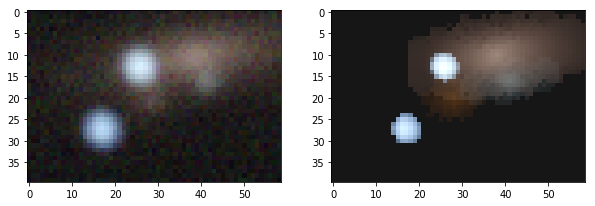

In [16]:
model = blend.get_model()
img_rgb = scarlet.display.img_to_rgb(images, filter_indices=[3,2,1], norm=asinh)
model_rgb = scarlet.display.img_to_rgb(model, filter_indices=[3,2,1], norm=asinh)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].imshow(img_rgb)
axes[1].imshow(model_rgb)
plt.show()

Notice that the result does *not* look very much like the model. This is because when `get_model` is called from either a [Component](component.ipynb#scarlet.component.Component) or a [Blend](blend.ipynb#scarlet.blend.Blend) it returns the model in the [Scene](observation.ipynb#scarlet.observation.Scene) frame (both in terms of resolution and target PSF), since that is the space where the model exists. To convert the model to the observation frame we need to use [Observation.get_model](observation.ipynb#scarlet.observation.Observation.get_model):

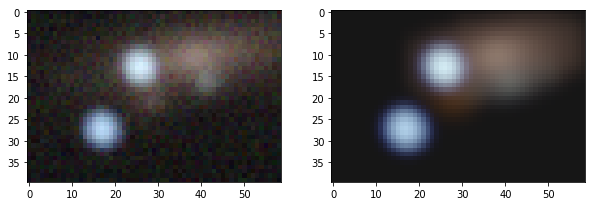

In [17]:
_model = blend.get_model()
model = observation.get_model(_model)
img_rgb = scarlet.display.img_to_rgb(images, filter_indices=[3,2,1], norm=asinh)
model_rgb = scarlet.display.img_to_rgb(model, filter_indices=[3,2,1], norm=asinh)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].imshow(img_rgb)
axes[1].imshow(model_rgb)
plt.show()

It is also possible to load the model for each source individually:

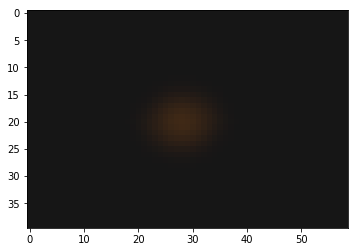

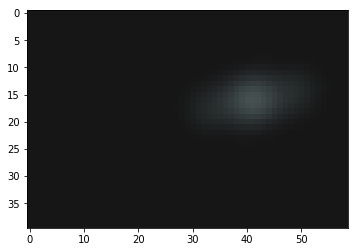

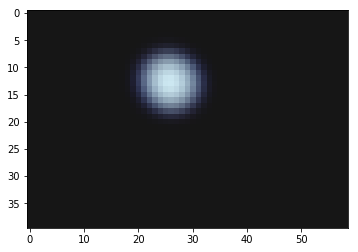

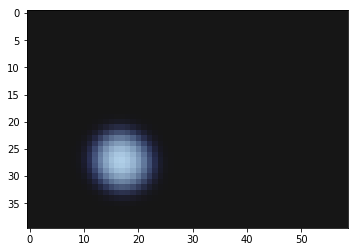

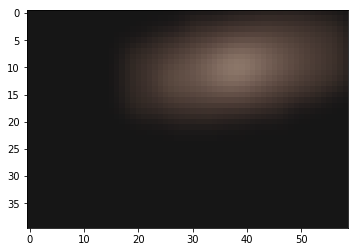

In [18]:
for src in blend.sources:
    _model = src.get_model()
    model = observation.get_model(_model)
    model_rgb = scarlet.display.img_to_rgb(model, filter_indices=[3,2,1], norm=asinh)
    plt.imshow(model_rgb)
    plt.show()

It is also possible to display all of the components for a given blend, which is useful when one or more sources have multiple components. In this case, because each source was initialized with a single component, there is no difference:

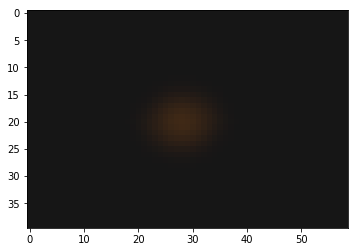

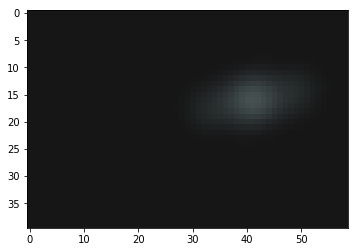

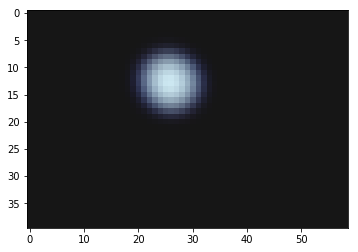

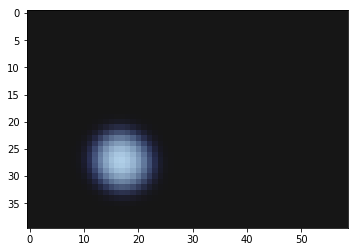

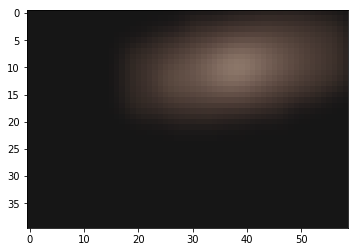

In [19]:
for component in blend.components:
    _model = component.get_model()
    model = observation.get_model(_model)
    model_rgb = scarlet.display.img_to_rgb(model, filter_indices=[3,2,1], norm=asinh)
    plt.imshow(model_rgb)
    plt.show()

## Checking for Flags and Convergence

### BlendFlag

The [BlendFlag](component.ipynb#scarlet.component.BlendFlag) class is used to keep track of any potential problems that may have arisen during deblending. The two most useful kesy are `BlendFlag.SED_NOT_CONVERGED` and `BlendFlag.MORPH_NOT_CONVERGED`, which indicate that the SED and morphology have not converged respectively. This can be useful when testing out a new source class or set of observations to understand why blends are not converging as expected.

While not implemented yet, [BlendFlag](component.ipynb#scarlet.component.BlendFlag) can also indicate whether a source had pixels on the edge of the frame in the model scene, which means any shapes or fluxes measured might be incorrect, and whether or not the source had zero flux.

### Convergence

Convergence of the entire blend can also be tested using the [Blend.converged](blend.ipynb#scarlet.blend.Blend.converged) property, which is only true if the SED and morphology have converged for every source.

Putting these concepts together we can create a `History` class that allows us to track the convergence of our sources in each iteration:

In [29]:
class History(scarlet.ExtendedSource):
    def __init__(self, *args, **kwargs):
        # The location of the center in each iteration
        self.center_history = []
        # The convergence in each iteration
        self.convergence_hist = []
        # The number of each iteration
        self.iterations = []
        super().__init__(*args, **kwargs)

    def update(self):
        """Update the history and the parameters
        """
        if self._parent is None:
            it = 0
        else:
            it = self._parent.it
        self.update_history(it)
        return super().update()
    
    def update_history(self, it):
        """Update the center and convergence history
        """
        self.center_history.append(self.pixel_center)
        self.iterations.append(it)
        _sed = self.flags & scarlet.BlendFlag.SED_NOT_CONVERGED
        _morph = self.flags & scarlet.BlendFlag.MORPH_NOT_CONVERGED
        # Add a color that can be used by the plot to indicate which paremeters
        # have converged
        if _sed and _morph:
            self.convergence_hist.append("black")
        elif _sed:
            self.convergence_hist.append("cyan")
        elif _morph:
            self.convergence_hist.append("red")
        else:
            self.convergence_hist.append("green")

sources = []
for idx in np.unique(catalog["index"]):
    src = catalog[catalog["index"]==idx][0]
    sources.append(History((src['y'],src['x']), scene, observation, bg_rms))

With our new source list we can deblend again and then track the convergence of each source by plotting its pixel center in x and y. Black dots indicate that neither the SED and morphology converged for a source, red dots indicate that only the SED converged for a source, cyan dots indicate that only the morphology converged, and green dots indicate that both the SED and morphology converged for a source in a given iteration:

Total iterations: 24


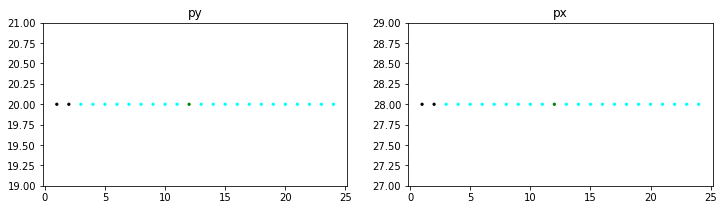

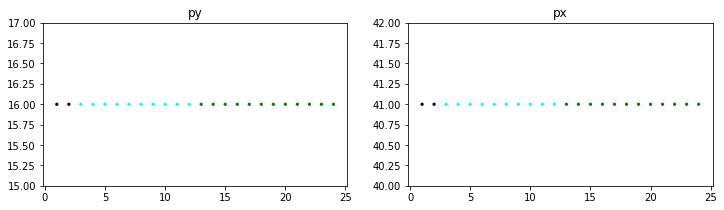

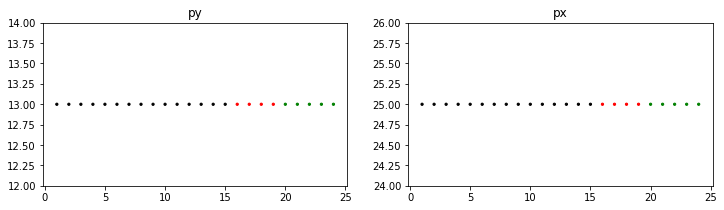

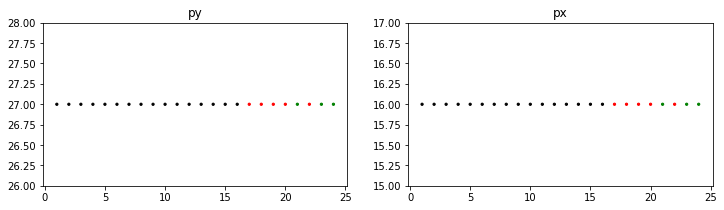

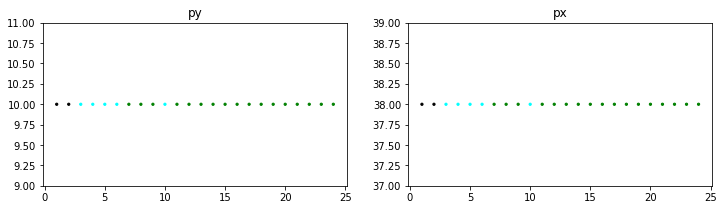

In [30]:
# Create and fit the blend
blend = scarlet.Blend(scene, sources, observation)
blend.fit(100, 1e-2, False)
print("Total iterations:", blend.it)

# Show the history of pixel positions and convergence
for k,src in enumerate(blend.sources):
    history = np.array(src.center_history)
    hy = history[:, 0]
    hx = history[:, 1]
    fig = plt.figure(figsize=(12,3 ))
    ax = [fig.add_subplot(1, 2, n+1) for n in range(2)]
    x = src.iterations
    ax[0].scatter(x, hy, c=src.convergence_hist, s=5)
    ax[0].set_title("py")
    ax[1].scatter(x, hx, c=src.convergence_hist, s=5)
    ax[1].set_title("px")
    ax[0].set_ylim([hy[-1]-1, hy[-1]+1])
    ax[1].set_ylim([hx[-1]-1, hx[-1]+1])

    plt.show()

This concludes the overview. The user is referred to the [API Documentation](api_docs.rst) for more details about the objects used in *scarlet*.